In [1]:
# Scratch

In [1]:
import sys
sys.path.append('/n/home02/pbb/scripts/halo-metadata-server/Selenkay/bin/')
from Functions import calccover, calcPercentileHeights, heightAggMetrics, canopyLayerMetrics
from Classes import Cloud
import geopandas as gpd
import pandas as pd
import numpy as np
import concurrent.futures
from pathlib import Path
import laspy
import time
import matplotlib.pyplot as plt
import seaborn as sns

# # # USER INPUTS

# Path to a shapefile (.shp) of polygon features matching the las files
# NOTE: This should be the same input shapefile as in 1-ClipLasWithPolygons.ipynb
# Path to directory of shapefiles (.shp) of polygon features to clip the point cloud with.
shpf = Path('/n/home02/pbb/scripts/halo-metadata-server/Selenkay/data/in/BoundaryShapefiles/SelenkaySpotPolygons_IncreasingRadius/SelenkaySpotPolygons_30mRadius.shp')

# Path to directory of shapefiles (.shp) of polygon features to clip the point cloud with.
# shpd = Path('/n/home02/pbb/scripts/halo-metadata-server/Selenkay/data/in/BoundaryShapefiles/SelenkaySpotPolygons_IncreasingRadius')

# Input directory of clipped las files to compute metrics with.
# NOTE: This should be the same as the 'od' directory from 1-ClipLasWithPolygons.ipynb
ld = Path('/n/davies_lab/Users/pbb/SelenkayDiversity/data/out/SpotPolys_Fibonacci_ClippedLas/30mRadius/')

lasinputs = [l for l in ld.glob('*.las')]
          
# outdirectory for metric output files
od_metrics = Path('/n/davies_lab/Users/pbb/SelenkayDiversity/data/out/Metrics/30mRadius/')
                    
# Outdirectory for rasters
outdir_rast = Path('/n/davies_lab/Users/pbb/SelenkayDiversity/data/out/Rasters/30mRadius/')

# EPSG code of the shapefile and the las files, as a string
# Note: Shapefiles and las files must have the same EPSG code (same CRS)
# Kruger is 32736 (WGS84 UTM 36S)
# Mpala is 32637 (WGS84 UTM 37N)
# Selenkay is 32737 (WGS84 UTM37S)
epsg='32737'

# feature id column - name of attribute column in shapefile which defines each polygon feature with a unique ID
featureIDcol = 'Spot'

# Max height of voxel stacks 
# NOTE: Set this to be just above max height of your trees in meters.
stackheight=15

# Horizontal Res of Grid (XY pixel size)
xysize=0.5

# Vertical step size for metrics
# NOTE: This defines the vertical bin size in meters (how "thick" each voxel is).
verticalres = 0.5

# Ground threshold (i.e. below this height treat points as ground) in meters
groundthreshold = 0.05

# height col
heightcol = 'HeightAboveGround'

# # # END USER INPUTS

In [2]:
# JUST FOR TESTING 10/17/22
lasf = '/n/davies_lab/Users/pbb/SelenkayDiversity/data/out/SpotPolys_Fibonacci_ClippedLas/30mRadius/Spot_8B.las'

# Make a las cloud class, and grid it
lc = Cloud(lasf=lasf,
           gridsize=xysize,
           vsize=verticalres,
           heightcol=heightcol,
           maxh=stackheight)

# Calculate height statistics, and return an array of the point heights
perc, heights = calcPercentileHeights(points=lc.las.points,
                                      groundthres=groundthreshold,
                                      returnHeights=True,
                                      heightcol=heightcol)

# Stick it all in a dictionary for output
complexity = canopyLayerMetrics(h=heights,
                                hmax=stackheight,
                                step=lc.vsize,
                                groundthres=groundthreshold,
                                smoothsigma=1)
# Calculate Cover
cover = calccover(points=lc.las.points,
                  step=verticalres,
                  groundthres=groundthreshold,
                  heightcol=heightcol)


In [14]:
lc.makegrid()

# set the cell indices to loop over in parallel
indices = lc.grid_dict['idx_cells']

cover_dict = {}
perc_dict = {}
height_dict = {}
complexity_dict = {}


for index in indices:

    # make a True/False array 
    # for all points within the current grid cell
    idx_bool = lc.grid_dict['idx_points'] == lc.grid_dict['idx_cells'][index]
    
    # Calculate Cover
    cover_dict[index] = calccover(points=lc.las.points[idx_bool],
                                  step=verticalres,
                                  groundthres=groundthreshold,
                                  heightcol=heightcol)
    
    
    # Calculate height statistics, and return an array of the point heights
    perc_dict[index], height_dict[index] = calcPercentileHeights(points=lc.las.points[idx_bool],
                                          groundthres=groundthreshold,
                                          returnHeights=True,
                                          heightcol=heightcol)
    
    # Compute complexity metrics
    complexity_dict[index] = canopyLayerMetrics(h=heights,
                                    hmax=stackheight,
                                    step=lc.vsize,
                                    groundthres=groundthreshold,
                                    smoothsigma=1)

#     try:

#         # Calculate Cover
#         cover_dict[index] = calccover(points=lc.las.points[idx_bool],
#                                       step=verticalres,
#                                       groundthres=groundthreshold,
#                                       heightcol=heightcol)

#     except Exception as e:

#         print(f"Cover Calc. - {e.__class__} for {lc.lasf}: \n")
#         print(f"\t{e}\n")

/n/home02/pbb/scripts/halo-metadata-server/Selenkay/bin/Functions.py:839: RuntimeWarning: invalid value encountered in multiply
  FHD = -1*np.sum(hcounts_norm*np.log(hcounts_norm, where=hcounts_norm>0))


In [18]:
for k in height_dict.keys():
    if not cover_dict[k]:
        print(k)

In [19]:
 complexity_dict[index]

{'nlaysers': 1,
 'gapsize': 0,
 'maxpeakh': 0.42,
 'ptoh': 0.124,
 'cscore': 0.258,
 'FHD': 0.807,
 'VDR': 0.98,
 'meanpeakh': 0.42,
 'stdpeakh': 0,
 'cvpeakh': 0}

In [22]:
height_dict[index]

array([], dtype=float32)

(0.0, 15.3)

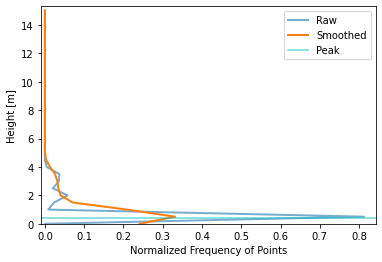

In [6]:
# TESTING FOR Processing Metrics scripts
from scipy.ndimage import gaussian_filter1d

hmin=0
hmax=15
step=0.5
groundthres=groundthreshold
smoothsigma=1
h = heights

# Calc Cover for height bins
nbins = ((hmax - hmin) / step) + 1
hbins = np.linspace(hmin, hmax, int(nbins))

# IMPORTANT: Using groundthres, you may want to account for errors in relative accuracy
# EX: IF the rel. accuracy of ground is about 0.06 m (6 cm) between flightlines,
# the lowest height bin could be set to 0.06 (instead of 0) to account for this.
# so any hit below 0.06 m counts as ground.
# NOTE: If you want to use everything, just set groundthres to 0
if groundthres > 0:
    # insert the groundthres into the array (right above 0)
    heightbins = np.insert(hbins, 1, groundthres)
    # heightbins[heightbins==0] = groundthres
if groundthres < 0:
    # insert the groundthres into the array (right below 0)
    heightbins = np.insert(hbins, 0, groundthres)
    # heightbins[heightbins==0] = groundthres

# sort points by height
h = np.sort(h)

# Group each point by height bin
hgroups = np.digitize(h, bins=hbins)

# Count the number of points in each bin
# Note: minlength allows it to go to the full length of hbins, rather than stop at the max height of the points
hcounts = np.bincount(hgroups, minlength=len(hbins))

# Normalize the counts
hcounts_norm = hcounts/np.sum(hcounts)

# Smooth point height distribution, and find peaks and troughs\
# Following the below article on stack exchange
# https://stackoverflow.com/questions/62537703/how-to-find-inflection-point-in-python

# smooth with gaussian filter (sigma = 2 m)
smooth = gaussian_filter1d(hcounts_norm, smoothsigma)

# compute first derivative
smooth_d1 = np.gradient(smooth)

        
# Interpolate heights and derivative to 1 cm increments so that you have more precise inflection points
hbins_interp= np.arange(0, np.max(hbins), 0.01)
smooth_d1_interp = np.interp(x=hbins_interp, xp=hbins, fp=smooth_d1)

# find inflection points
# when it switches from positive to negative (a trough)
idx_troughs = np.where(np.diff(np.sign(smooth_d1_interp))>0)[0]
# when it switches from negative to positive (a peak)
idx_peaks = np.where(np.diff(np.sign(smooth_d1_interp))<0)[0]

# output height values of peaks and troughs
troughs = hbins_interp[idx_troughs]
peaks = hbins_interp[idx_peaks]
# # find inflection points
# # when it switches from positive to negative (a trough)
# idx_troughs = np.where(np.diff(np.sign(smooth_d1))>0)[0]

# # when it switches from negative to positive (a peak)
# idx_peaks = np.where(np.diff(np.sign(smooth_d1))<0)[0]

# # output height values of peaks and troughs
# troughs = hbins[idx_troughs]
# peaks = hbins[idx_peaks]

# Number of layers as number of peaks
nlayers = len(peaks)

fig, ax = plt.subplots()
ax.plot(hcounts_norm, hbins, label='Raw', lw=2, alpha=0.6)
ax.plot(smooth, hbins, label='Smoothed', lw=2)
# for infl in troughs:
#     tline = ax.axhline(y=infl, color='b', label='Trough', alpha=0.6)
for infl in peaks:
    pline = ax.axhline(y=infl, color='c', label='Peak', alpha=0.6)
# ax.legend(handles=[tline, pline], loc='best')
ax.legend(loc='best')
ax.set_xlabel('Normalized Frequency of Points')
ax.set_ylabel('Height [m]')
ax.set_xlim(-0.01, np.max(hcounts_norm) + 0.03)
ax.set_ylim(0, np.max(hbins) + 0.3)

In [5]:
cvpeakh = np.mean(peaks)/np.std(peaks)

/tmp/ipykernel_93710/222727284.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  cvpeakh = np.mean(peaks)/np.std(peaks)


In [5]:
np.mean(peaks)

0.0

In [6]:
np.std(peaks)

0.0

In [9]:
cvpeakh

nan